In [1]:
from tqdm.notebook import tqdm

import json, pickle, base64, io

import numpy as np
import torch as T
import torchvision as TV

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def img2buf(img):
    buf = io.BytesIO()
    img.save(buf, format='JPEG')
    buf = str(base64.b64encode(buf.getvalue()))[2:-1]
    return buf

def buf2img(buf):
    img = Image.open(io.BytesIO(base64.b64decode(buf))).convert('RGB')
    return img

In [3]:
TXT = json.load(open('msrvtt.json', 'r'))

tsv, ldx = open('msrvtt.tsv', 'w'), {}
for vid in tqdm(TXT):
    ldx[vid] = tsv.tell()
    
    tsv.write(vid)
    for i in range(5):
        img = Image.open('_src/%s_%d.jpg'%(vid, i)).convert('RGB')
        buf = img2buf(img)
        tsv.write('\t'+buf)
    tsv.write('\n')
    tsv.flush()
pickle.dump(ldx, open('msrvtt.ldx', 'wb'))

  0%|          | 0/13 [00:00<?, ?it/s]

In [4]:
TSV, LDX = open('msrvtt.tsv', 'r'), pickle.load(open('msrvtt.ldx', 'rb'))

video7652: ['plywood is laid on a floor and a man installs more boards']


/tmp/ipykernel_32439/1565253376.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('15%d'%(i)), plt.xticks([]), plt.yticks([]), plt.imshow(img)


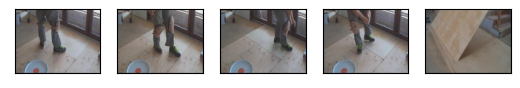

video7185: ['animated characters are dancing to the  old mcdonald song']


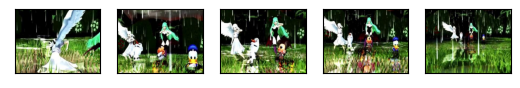

video9848: ['in this soundless video a woman with a headache demonstrates how to use shades to reduce bright light']


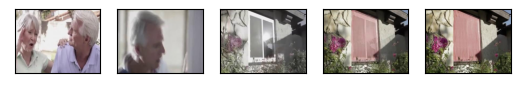

video8501: ['a girl talks about a school s athletic program']


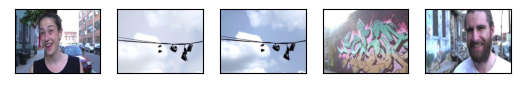

video8559: ['a cartoon involving animals']


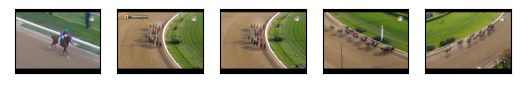

In [5]:
for I, vid in enumerate(TXT):
    print('%s:'%(vid), TXT[vid]['caption'])
    
    TSV.seek(LDX[vid])
    lines = TSV.readline().split('\t')
    plt.figure()
    for i in range(1, 6):
        buf = lines[i]
        img = buf2img(buf)
        plt.subplot('15%d'%(i)), plt.xticks([]), plt.yticks([]), plt.imshow(img)
    plt.show(), plt.close()
        
    if I==4: break

4 torch.Size([4, 5, 3, 224, 224]) torch.Size([4, 25])
video9668: [CLS] a man is driving a car [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


/tmp/ipykernel_32439/1097709021.py:53: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('15%d'%(i)), plt.xticks([]), plt.yticks([]), plt.imshow(img)


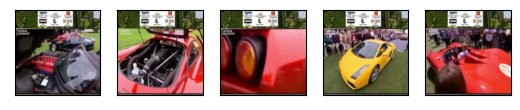

4 torch.Size([4, 5, 3, 224, 224]) torch.Size([4, 25])
video8501: [CLS] a girl talks about a school s athletic program [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


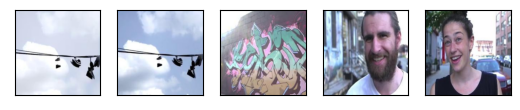

4 torch.Size([4, 5, 3, 224, 224]) torch.Size([4, 25])
video7813: [CLS] a person is dancing to the music [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


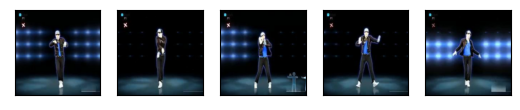

1 torch.Size([1, 5, 3, 224, 224]) torch.Size([1, 25])
video9531: [CLS] stephen colbert is interviewed for a video [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


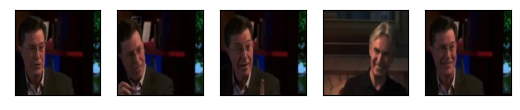

In [6]:
import transformers

class DS(T.utils.data.Dataset):
    def __init__(self, name):
        super().__init__()
        
        self.name = name
        
        self.TXT = json.load(open('%s.json'%(self.name), 'r'))
        self.LST = [vid for vid in self.TXT]
        self.LDX = pickle.load(open('%s.ldx'%(self.name), 'rb'))
        
        self.tokzr = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')
    
    def load_tsv(self, worker_id):
        self.TSV = open('%s.tsv'%(self.name), 'r')
    
    def __len__(self):
        return len(self.LST)
    
    def __getitem__(self, idx):
        vid = self.LST[idx]
        
        txt = self.TXT[vid]['caption'][0]
        txt = self.tokzr.encode(txt, padding='max_length', max_length=25, truncation=True)
        txt = np.array(txt, dtype=np.int64)
        
        self.TSV.seek(self.LDX[vid])
        lines = self.TSV.readline().split('\t')
        
        imgs = []
        for i in range(1, 6):
            buf = lines[i]
            img = buf2img(buf)
            img = TV.transforms.Compose([TV.transforms.CenterCrop(min(img.size)), 
                                         TV.transforms.Resize(224), 
                                         TV.transforms.ToTensor()])(img)
            imgs.append(img.unsqueeze(0))
        imgs = T.cat(imgs, dim=0)
        
        return vid, imgs, txt
        
ds = DS('msrvtt')
dl = T.utils.data.DataLoader(ds, batch_size=4, num_workers=2, shuffle=True, 
                             worker_init_fn=ds.load_tsv)
for vid, imgs, txt in dl:
    print(len(vid), imgs.shape, txt.shape)
    
    print('%s:'%(vid[0]), ds.tokzr.decode(txt[0]))
    plt.figure()
    for i in range(5):
        img = Image.fromarray((imgs[0, i].permute(1, 2, 0).numpy()*255.0).astype(np.uint8))
        plt.subplot('15%d'%(i)), plt.xticks([]), plt.yticks([]), plt.imshow(img)
    plt.show(), plt.close()